In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg


plt.style.use('seaborn')
%matplotlib inline

# 1. Polynomial Regression and Step Functions

In [2]:
from sklearn.preprocessing import PolynomialFeatures

In [3]:
wage = sm.datasets.get_rdataset('Wage', 'ISLR').data
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
X1 = PolynomialFeatures(1).fit_transform(wage.age.values.reshape((-1, 1)))
X2 = PolynomialFeatures(2).fit_transform(wage.age.values.reshape((-1, 1)))
X3 = PolynomialFeatures(3).fit_transform(wage.age.values.reshape((-1, 1)))
X4 = PolynomialFeatures(4).fit_transform(wage.age.values.reshape((-1, 1)))
X5 = PolynomialFeatures(5).fit_transform(wage.age.values.reshape((-1, 1)))

In [5]:
fit2 = sm.OLS(wage['wage'], X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [6]:
age_grid = np.arange(wage.age.min(), wage.age.max() + 1).reshape(-1,1)
X_test = PolynomialFeatures(4).fit_transform(age_grid)

result = fit2.get_prediction(X_test)

preds = result.predicted_mean
se = result.se_mean

bands = result.conf_int()

In [7]:
fit_1 = sm.GLS(wage['wage'], X1).fit()
fit_2 = sm.GLS(wage['wage'], X2).fit()
fit_3 = sm.GLS(wage['wage'], X3).fit()
fit_4 = sm.GLS(wage['wage'], X4).fit()
fit_5 = sm.GLS(wage['wage'], X5).fit()

In [8]:
sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [9]:
fit5 = sm.OLS(wage['wage'], X5).fit()
fit5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-49.7046,161.435,-0.308,0.758,-366.239,266.830
x1,3.9930,20.110,0.199,0.843,-35.438,43.424
x2,0.2760,0.958,0.288,0.773,-1.603,2.155
x3,-0.0126,0.022,-0.577,0.564,-0.056,0.030
x4,0.0002,0.000,0.762,0.446,-0.000,0.001
x5,-9.157e-07,1.02e-06,-0.897,0.370,-2.92e-06,1.09e-06


In [10]:
y = (wage['wage'] > 250).map({True: 1, False: 0})
y

231655    0
86582     0
161300    0
155159    0
11443     0
         ..
376816    0
302281    0
10033     0
14375     0
453557    0
Name: wage, Length: 3000, dtype: int64

In [11]:
fit = sm.GLM(y, X4, 
             family=sm.families.Binomial()).fit()

In [12]:
result = fit.get_prediction(
    PolynomialFeatures(4).fit_transform(age_grid))
preds2 = result.predicted_mean
se = result.se_mean

Text(0, 0.5, 'Pr(Wage > 250 | Age)')

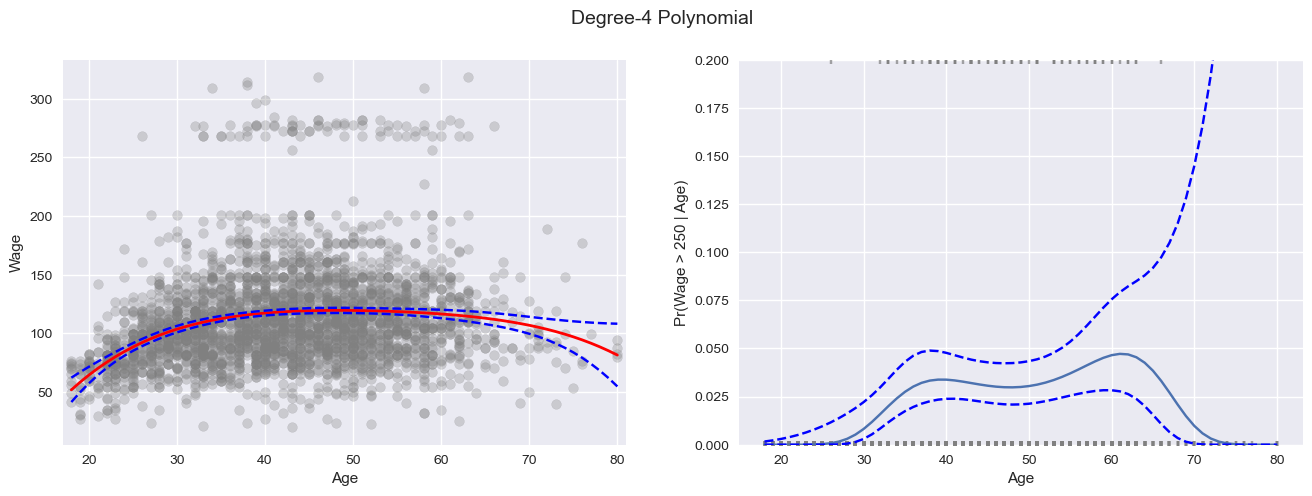

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

ax1.scatter(wage['age'], wage['wage'], alpha=0.3, facecolor=None, c='grey')
ax1.plot(age_grid, preds, lw=2, c='red')
ax1.plot(age_grid, bands[:, 0], 'b--')
ax1.plot(age_grid, bands[:, 1], 'b--')
ax1.set_xlim(wage.age.min() - 1, wage.age.max() + 1)
ax1.set_xlabel('Age')
ax1.set_ylabel('Wage')

ax2.set_ylim(0, 0.2)
ax2.plot(age_grid, preds2)
ax2.scatter(wage['age'], y/5, s=30, c='grey', marker='|', alpha=0.7)
ax2.plot(age_grid, result.conf_int()[:, 0], 'b--')
ax2.plot(age_grid, result.conf_int()[:, 1], 'b--')
ax2.set_xlabel('Age')
ax2.set_ylabel('Pr(Wage > 250 | Age)')

In [14]:
wage['bin'] = pd.cut(wage['age'], bins=4)

In [15]:
fit = smf.ols('wage~ C(bin)', data=wage).fit()

In [16]:
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,94.1584,1.476,63.790,0.000,91.264,97.053
"C(bin)[T.Interval(33.5, 49.0, closed='right')]",24.0535,1.829,13.148,0.000,20.466,27.641
"C(bin)[T.Interval(49.0, 64.5, closed='right')]",23.6646,2.068,11.443,0.000,19.610,27.719
"C(bin)[T.Interval(64.5, 80.0, closed='right')]",7.6406,4.987,1.532,0.126,-2.139,17.420


# 2. Splines

In [17]:
from patsy import dmatrix

In [18]:
# Specifying 3 knots
transformed_x1 = dmatrix("bs(wage.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"wage.age": wage.age}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(wage.wage, transformed_x1).fit()

transformed_agegrid = dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"age_grid": age_grid}, return_type='dataframe')

result = fit1.get_prediction(transformed_agegrid)

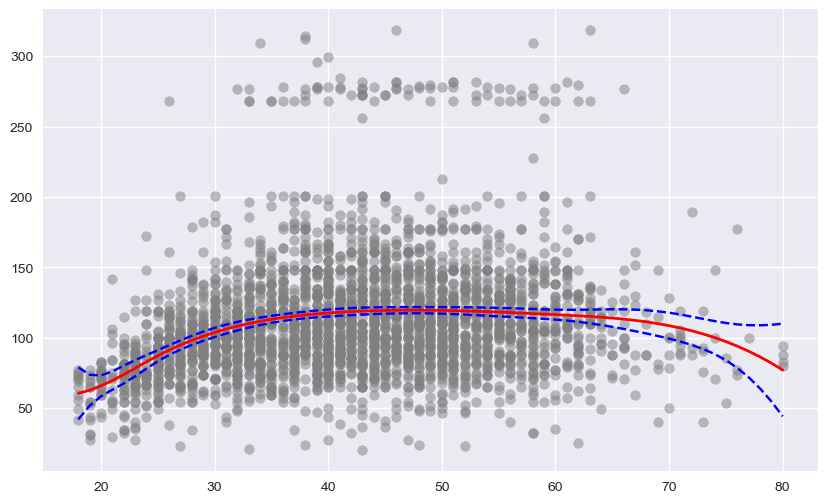

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(wage['age'], wage['wage'], c='gray', alpha=0.5, facecolor=None)
ax.plot(age_grid, result.predicted_mean, lw=2, c='red')
ax.plot(age_grid, result.conf_int()[:, 0], 'b--')
ax.plot(age_grid, result.conf_int()[:, 1], 'b--')

In [20]:
transformed_x1.shape

(3000, 7)

In [21]:
transformed_x2 = dmatrix("cr(wage.age, df=4)",
                        {"wage.age": wage.age}, return_type='dataframe')

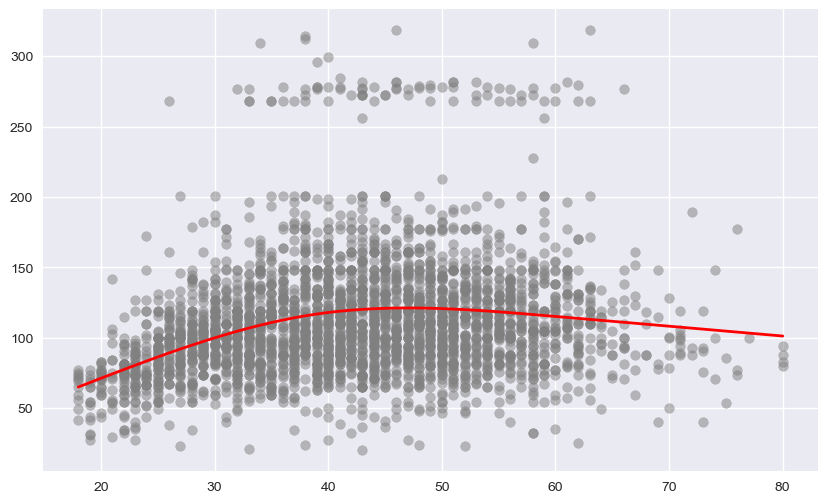

In [22]:
fit2 = sm.GLM(wage.wage, transformed_x2).fit()

transformed_agegrid = dmatrix("cr(age_grid, df=4)",
                        {"age_grid": age_grid}, return_type='dataframe')

result = fit2.get_prediction(transformed_agegrid)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(wage['age'], wage['wage'], c='gray', alpha=0.5, facecolor=None)
ax.plot(age_grid, result.predicted_mean, lw=2, c='red')

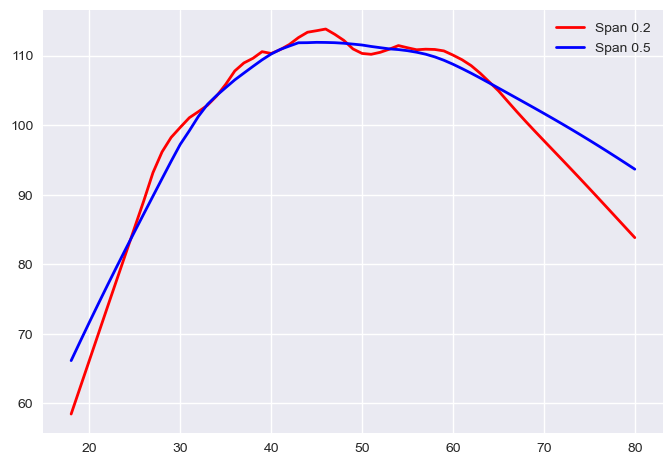

In [23]:
fit1 = sm.nonparametric.lowess(
    wage['wage'], wage['age'], xvals=age_grid.squeeze(), frac=0.2
)

fit2 = sm.nonparametric.lowess(
    wage['wage'], wage['age'], xvals=age_grid.squeeze(), frac=0.5
)

plt.plot(age_grid, fit1, lw=2, c='red', label='Span 0.2')
plt.plot(age_grid, fit2, lw=2, c='blue', label='Span 0.5')
plt.legend()

# 3. GAMs

In [24]:
gam1 = smf.ols('wage ~ C(education) + cr(year, df=4) + cr(age, df=5)', 
               data=wage).fit()

In [25]:
gam1.params

Intercept                             52.005899
C(education)[T.2. HS Grad]            10.785791
C(education)[T.3. Some College]       23.182029
C(education)[T.4. College Grad]       37.859841
C(education)[T.5. Advanced Degree]    62.301727
cr(year, df=4)[0]                      8.567523
cr(year, df=4)[1]                     12.971170
cr(year, df=4)[2]                     14.581938
cr(year, df=4)[3]                     15.885267
cr(age, df=5)[0]                     -19.109869
cr(age, df=5)[1]                      18.608717
cr(age, df=5)[2]                      27.404770
cr(age, df=5)[3]                      22.367363
cr(age, df=5)[4]                       2.734918
dtype: float64

In [26]:
from statsmodels.gam.api import GLMGam, BSplines

In [27]:
x_spline = wage[['year', 'age']]
bs = BSplines(x_spline, df=[4, 5], degree=[3, 3], include_intercept=True)

gam_bs = GLMGam.from_formula('wage ~ education', data=wage,
                smoother=bs)
res_bs = gam_bs.fit()

In [28]:
res_bs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                         GLMGam   Df Residuals:                     2988
Model Family:                Gaussian   Df Model:                        11.00
Link Function:               identity   Scale:                          1238.8
Method:                         PIRLS   Log-Likelihood:                -14934.
Date:                Tue, 18 Oct 2022   Deviance:                   3.7014e+06
Time:                        21:54:12   Pearson chi2:                 3.70e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3358
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          53.1543      1.936     27.450      0.000      49.359      56.950
education[T.2. HS Grad]            10.7413      2.431      4.418      0.000       5.977      15.506
education[T.3. Some College]       23.2067      2.563      9.056      0.000      18.184      28.229
education[T.4. College Grad]       37.8704      2.547     14.871      0.000      32.879      42.862
education[T.5. Advanced Degree]    62.4355      2.764     22.591      0.000      57.019      67.852
year_s0                             8.4332      1.554      5.428      0.000       5.388      11.478
year_s1                            15.1363      4.066      3.723      0.000       7.167      23.106
year_s2                            13.6367      4.213      3.237      0.001       5.379      21.894
year_s3                            15.9481      1.748      9.123      0.000      12.522      19.374
age_s0                            -19.8625      4.275     -4.646      0.000     -28.241     -11.484
age_s1                              7.0357      4.707      1.495      0.135      -2.189      16.261
age_s2                             44.5714      5.524      8.069      0.000      33.745      55.398
age_s3                             13.3561      7.596      1.758      0.079      -1.533      28.245
age_s4                              8.0536      9.213      0.874      0.382     -10.004      26.112
===================================================================================================
"""

In [29]:
from pygam import LinearGAM, s, f

In [30]:
X = wage[['year', 'age', 'education']].assign(
    education = lambda df: df.education.str.extract(r'^(\d)').astype('float') - 1
)
y = wage['wage'].copy()

In [31]:
X.head()

,year,age,education
231655,2006,18,0.0
86582,2004,24,3.0
161300,2003,45,2.0
155159,2003,43,3.0
11443,2005,50,1.0


In [32]:
gam = LinearGAM(s(0, spline_order=4) + s(1, spline_order=5) + f(2))

In [33]:
gam.gridsearch(X.values, y.values)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

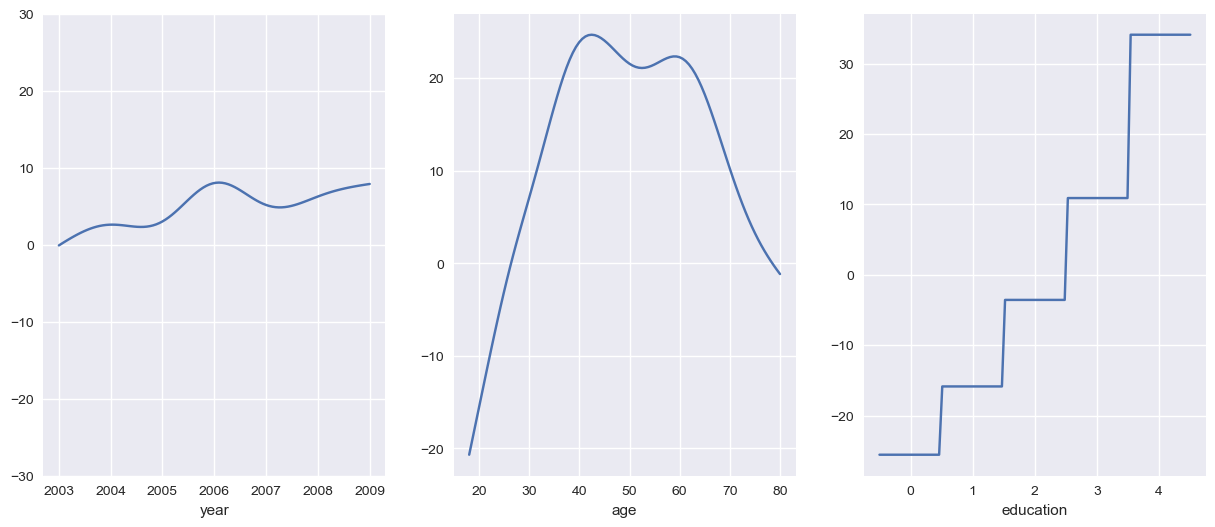

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

names = ['year', 'age', 'education']

for i, ax in enumerate(axes):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.set(xlabel=names[i])
    if i == 0:
        ax.set_ylim(-30,30)